## CIFAR10 с MobileNet V2

In [1]:
import torch
import torchvision
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
import copy
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

### Загрузка данных
#### Предобработка данных заключается в первоначальном изменении исходного изображения 32 х 32 до 224 х 224, так как это минимальные небходимый размер для сети MobileNet V2 из хаба pytorch, преобразовании их к тензору pytorch-а и приведению мат ожидания и дисперсии каждого канала изображения к следующим значенениям



In [2]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize(224),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch = 100

dataset_sizes = {'train': 50000, 'val': 10000}

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch, shuffle=True, num_workers=4)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch, shuffle=False, num_workers=4)

dataloaders = {'train': trainloader, 'val': testloader}

Files already downloaded and verified
Files already downloaded and verified


### Загрузка модели MobileNet V2

In [3]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

### Функция обучения нейросети
#### В функции осуществляется обучение и валидация
#### Входные параметры: модель, оптимизируемый функционал, оптимизатор, планировщик изменения значения скорости обучения, количество эпох

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  
  for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)
    
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0
      
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
      if phase == 'train':
        scheduler.step()
      
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      
      print(f'{phase:<6} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
      
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
  model.load_state_dict(best_model_wts)
  return model

### Исходная архитектура сети была изменена
#### Вместо одного последнего слоя были добавлены две повторяющиеся связки из Linear + Dropout + ReLU
#### Выходным является линейный слой с 10-ю выходами
#### Так же для обучения были выбраны следующие слои:
#### 1. Последние несколько слоев feature;
#### 2. Весь слой классификации.

In [5]:
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.3),
    torch.nn.Linear(in_features=1280, out_features=800, bias=True),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(p=0.3),
    torch.nn.Linear(in_features=800, out_features=100, bias=True),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(in_features=100, out_features=10, bias=True)
                                 )
# model.classifier[1] = torch.nn.Linear(in_features=1280, out_features=10, bias=True)
freeze_layer = 15
for x in list(model.features.parameters())[:freeze_layer]:
  x.requires_grad = False
for x in list(model.features[freeze_layer:].parameters())[freeze_layer:]:
  x.requires_grad = True
for x in model.classifier.parameters():
  x.requires_grad = True

In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
if device == 'cuda:0':
  model.cuda()

### Выбор алгоритмов обучения
#### Оптимизатором выбран Adam
#### Функцией потери выступила Кросс Энтропия

In [7]:
optimizer = optim.Adam(list(model.features.parameters())[freeze_layer:] + list(model.classifier.parameters()), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
exp_lr_sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.01)

In [8]:
best_model = train_model(model, loss_fn, optimizer, exp_lr_sheduler, num_epochs=5)

Epoch 1/5
----------
train  Loss: 0.5547 Acc: 0.8135
val    Loss: 0.4184 Acc: 0.8638

Epoch 2/5
----------
train  Loss: 0.3375 Acc: 0.8899
val    Loss: 0.3360 Acc: 0.8893

Epoch 3/5
----------
train  Loss: 0.2728 Acc: 0.9094
val    Loss: 0.3782 Acc: 0.8760

Epoch 4/5
----------
train  Loss: 0.2367 Acc: 0.9212
val    Loss: 0.3146 Acc: 0.8985

Epoch 5/5
----------
train  Loss: 0.2020 Acc: 0.9343
val    Loss: 0.2945 Acc: 0.9053

Best val Acc: 0.905300


### Построение матрицы классификации на валидационном датасете

In [9]:
def my_confusion_matrix(model, dataloader):
  conf_matrix = torch.zeros((10, 10)).to(device)
  for inputs, labels in dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)

    _, preds = torch.max(outputs, 1)
    conf_matrix += torch.from_numpy(
        confusion_matrix(labels.cpu().numpy(),
                         preds.cpu().numpy())).to(device)
  return conf_matrix

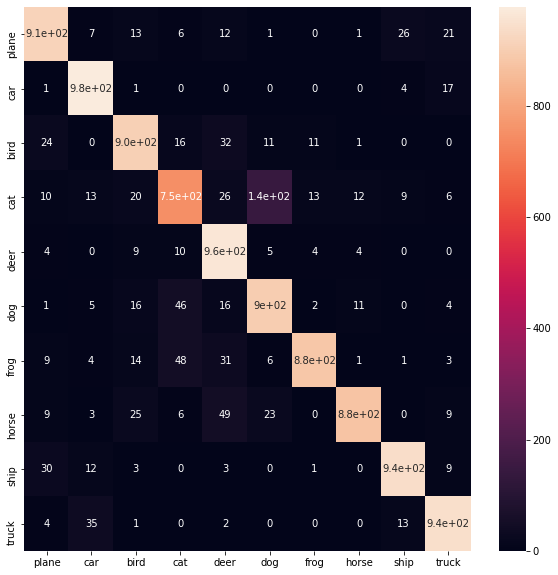

In [10]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
best_model.eval()
conf_m = pd.DataFrame(my_confusion_matrix(best_model, dataloaders['val']).cpu().numpy(), index=classes, columns=classes)
plt.figure(figsize = (10,10))
sns.heatmap(conf_m, annot=True)